# Spatiotemporal Wave Height Prediction using ConvLSTM Network

This notebook implements an end-to-end deep learning pipeline to predict spectral significant wave height (VHM0) using Copernicus Marine dataset.

**Author:** Expert Data Scientist  
**Objective:** Predict VHM0 using spatiotemporal patterns in oceanographic data  
**Model:** ConvLSTM2D for capturing both spatial and temporal dependencies

In [1]:
# # This will completely remove the current broken installation
# !pip uninstall scikit-learn -y

# # This will install a fresh, clean version of the library
# !pip install scikit-learn

In [1]:
import torch

# Check if the GPU is available
is_available = torch.cuda.is_available()
print(f"PyTorch can access the GPU: {is_available}")

# Print details if available
if is_available:
    gpu_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

PyTorch can access the GPU: True
Number of available GPUs: 2
GPU 0: NVIDIA GeForce GTX 1080 Ti
GPU 1: NVIDIA GeForce GTX 1080 Ti


In [3]:
# ==============================================================================
# Step 1: Environment Setup and Library Imports
# ==============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import os
import time

warnings.filterwarnings('ignore')
print(f"PyTorch Version: {torch.__version__}")
print("-" * 50)

# ==============================================================================
# Step 2: GPU Device Configuration (Crucial for GPU Training)
# ==============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
print("-" * 50)

# ==============================================================================
# Step 3: Data Loading (Same as your original notebook)
# ==============================================================================
data_path = 'cmems_mod_ibi_wav_anfc_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.97N_2022-12-01-2025-01-01-001.nc'

try:
    ds = xr.open_dataset(data_path)
    print("Dataset loaded successfully!")
    print(f"Dimensions: {dict(ds.dims)}")
except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"Dataset not found at the path: {data_path}")
    print("Please make sure the .nc file is in the same folder as your notebook.")
    # Exit if data is not found
    exit()
print("-" * 50)

# ==============================================================================
# Step 4: Data Preprocessing (Same logic, adapted for PyTorch)
# ==============================================================================
target_var = 'VHM0'
# Original feature_vars before circular conversion
original_feature_vars = ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR', 'VTPK', 'VSDX', 'VSDY']

# --- 4.1 Handle circular features (wave directions) ---
print("Processing circular features...")
ds_processed = ds.copy()
radians = np.deg2rad(ds_processed['VMDR'])
ds_processed['VMDR_sin'] = np.sin(radians)
ds_processed['VMDR_cos'] = np.cos(radians)
ds_processed = ds_processed.drop_vars(['VMDR'])

# Update feature variables list
feature_vars = ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR_sin', 'VMDR_cos', 'VTPK', 'VSDX', 'VSDY']
all_vars_to_process = [target_var] + feature_vars
print(f"Updated feature variables: {feature_vars}")

# --- 4.2 Reduce memory usage by converting to float32 ---
print(f"\nOriginal memory usage: {ds_processed.nbytes / 1e9:.2f} GB")
for var in ds_processed.data_vars:
    if ds_processed[var].dtype == 'float64':
        ds_processed[var] = ds_processed[var].astype('float32')
print(f"New memory usage after float32 conversion: {ds_processed.nbytes / 1e9:.2f} GB")

# --- 4.3 Fill NaN values (land mask) with 0 ---
ds_filled = ds_processed.fillna(0)
print("\nFilled NaN values with 0.")

# --- 4.4 Scale the data ---
print("\nScaling data...")
ds_scaled = ds_filled.copy()
scalers = {}

for var in all_vars_to_process:
    var_scaler = MinMaxScaler()
    var_data = ds_filled[var].values
    
    # Reshape for scaling: (time, lat*lon)
    original_shape = var_data.shape
    var_data_2d = var_data.reshape(original_shape[0], -1)
    
    # Fit and transform
    var_scaled_2d = var_scaler.fit_transform(var_data_2d)
    
    # Reshape back and update dataset
    ds_scaled[var] = (ds_filled[var].dims, var_scaled_2d.reshape(original_shape))
    scalers[var] = var_scaler
    print(f"  - Scaled {var}")

print("Data scaling completed!")
print("-" * 50)

# ==============================================================================
# Step 5: Create PyTorch Dataset and DataLoaders (PyTorch version of Generator)
# ==============================================================================
class WaveDataset(Dataset):
    """Custom PyTorch Dataset for on-the-fly batch generation."""
    def __init__(self, data, feature_vars, target_var, indices, lookback=24):
        self.data = data
        self.feature_vars = feature_vars
        self.target_var = target_var
        self.indices = indices
        self.lookback = lookback

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        seq_start_idx = self.indices[idx]
        seq_end_idx = seq_start_idx + self.lookback
        target_idx = seq_end_idx  # Forecast horizon of 1 hour

        # Extract features and stack them into a single tensor
        # Shape: (features, timesteps, lat, lon)
        features_list = [self.data[var].isel(time=slice(seq_start_idx, seq_end_idx)).values for var in self.feature_vars]
        X = np.stack(features_list, axis=0).astype(np.float32)
        
        # Extract target
        y = self.data[self.target_var].isel(time=target_idx).values.astype(np.float32)
        
        # PyTorch expects channels-first format: (timesteps, features, lat, lon)
        # So we permute the dimensions
        X = X.transpose(1, 0, 2, 3)
        
        # Add a channel dimension to the target
        y = np.expand_dims(y, axis=0)
        
        return torch.from_numpy(X), torch.from_numpy(y)

# --- Define parameters and split indices ---
lookback_hours = 24
batch_size = 8 # Adjust this based on your GPU memory

n_time = ds_scaled.dims['time']
n_sequences = n_time - lookback_hours
all_indices = np.arange(n_sequences)

# Chronological split
train_end = int(n_sequences * 0.7)
val_end = int(n_sequences * 0.85)

train_indices = all_indices[:train_end]
val_indices = all_indices[train_end:val_end]
test_indices = all_indices[val_end:]

# --- Instantiate Datasets and DataLoaders ---
train_dataset = WaveDataset(ds_scaled, feature_vars, target_var, train_indices, lookback=lookback_hours)
val_dataset = WaveDataset(ds_scaled, feature_vars, target_var, val_indices, lookback=lookback_hours)
test_dataset = WaveDataset(ds_scaled, feature_vars, target_var, test_indices, lookback=lookback_hours)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("PyTorch DataLoaders created successfully!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print("-" * 50)

# ==============================================================================
# Step 6: Build the PyTorch ConvLSTM Model (PyTorch version of your model)
# ==============================================================================
class ConvLSTMNet(nn.Module):
    def __init__(self, input_channels, hidden_channels=[64, 32], kernel_size=(3, 3), dropout_rate=0.2):
        super(ConvLSTMNet, self).__init__()
        
        self.convlstm1 = nn.ConvLSTM2d(
            input_dim=input_channels,
            hidden_dim=hidden_channels[0],
            kernel_size=kernel_size,
            num_layers=1,
            batch_first=True,
            padding='same'
        )
        # PyTorch Batch Norm for 5D tensor is BatchNorm3d
        self.batchnorm1 = nn.BatchNorm3d(hidden_channels[0])
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.convlstm2 = nn.ConvLSTM2d(
            input_dim=hidden_channels[0],
            hidden_dim=hidden_channels[1],
            kernel_size=kernel_size,
            num_layers=1,
            batch_first=True,
            padding='same'
        )
        self.batchnorm2 = nn.BatchNorm3d(hidden_channels[1])
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Output convolution
        self.conv_out = nn.Conv2d(
            in_channels=hidden_channels[1],
            out_channels=1, # Predicting one feature map (VHM0)
            kernel_size=(1, 1),
            padding='same'
        )

    def forward(self, x):
        # Layer 1
        _, (h1, _) = self.convlstm1(x)
        # Take the hidden state of the last time step
        x = h1[0] 
        # Note: BatchNorm and Dropout are tricky with RNNs. Applying to output.
        # x = self.dropout1(self.batchnorm1(x)) # Optional application
        
        # To feed into the next LSTM, we need to add a time dimension back
        x = x.unsqueeze(1)
        
        # Layer 2
        _, (h2, _) = self.convlstm2(x)
        x = h2[0]
        # x = self.dropout2(self.batchnorm2(x)) # Optional application
        
        # Output layer
        output = self.conv_out(x)
        return output

# --- Instantiate the model and move it to the GPU ---
input_channels = len(feature_vars)
model = ConvLSTMNet(input_channels=input_channels).to(device)
print("PyTorch model built and moved to GPU.")
print(model)
print("-" * 50)

# ==============================================================================
# Step 7: Define Loss Function, Optimizer, and Training Loop
# ==============================================================================
# --- 7.1 Custom Weighted MSE Loss in PyTorch ---
def weighted_mse_loss(output, target, weight_threshold=0.8):
    mse = (output - target) ** 2
    weights = torch.where(target > weight_threshold, 2.0, 1.0)
    weighted_mse = weights * mse
    return torch.mean(weighted_mse)

loss_function = weighted_mse_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Optimizer and Loss Function defined.")
print("-" * 50)

# --- 7.2 Training and Validation Loop ---
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=5, model_path='best_convlstm_model.pth'):
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()
        model.train() # Set model to training mode
        total_train_loss = 0.0
        
        for i, (X_batch, y_batch) in enumerate(train_loader):
            # Move data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            y_pred = model(X_batch)
            
            # Calculate loss
            loss = loss_fn(y_pred, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)
        
        # --- Validation ---
        model.eval() # Set model to evaluation mode
        total_val_loss = 0.0
        with torch.no_grad(): # No need to calculate gradients for validation
            for X_batch_val, y_batch_val in val_loader:
                X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)
                y_pred_val = model(X_batch_val)
                val_loss = loss_fn(y_pred_val, y_batch_val)
                total_val_loss += val_loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        end_time = time.time()
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | "
              f"Time: {end_time - start_time:.2f}s")
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"  -> New best model saved to {model_path}")
            
    print("\nTraining finished!")
    return model

# ==============================================================================
# Step 8: Start the Training
# ==============================================================================
print("--- Starting model training for 5 epochs ---")
# Train the model (set epochs to a higher number like 100 for a full run)
trained_model = train_model(model, train_loader, val_loader, optimizer, loss_function, epochs=5)
print("-" * 50)


# ==============================================================================
# Step 9: Evaluation and Visualization (using the trained PyTorch model)
# ==============================================================================
print("--- Evaluating the trained model on the test set ---")

# Load the best performing model
model.load_state_dict(torch.load('best_convlstm_model.pth'))
model.eval() # Set to evaluation mode

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for X_batch_test, y_batch_test in test_loader:
        X_batch_test = X_batch_test.to(device)
        y_pred_test = model(X_batch_test)
        
        # Move data back to CPU for numpy conversion and store
        all_y_true.append(y_batch_test.cpu().numpy())
        all_y_pred.append(y_pred_test.cpu().numpy())

# Concatenate all batches
y_test_scaled = np.concatenate(all_y_true, axis=0).squeeze()
y_pred_scaled = np.concatenate(all_y_pred, axis=0).squeeze()

# --- Inverse transform predictions to original scale ---
print("\nInverse transforming predictions...")
target_scaler = scalers[target_var]
y_test_orig = target_scaler.inverse_transform(y_test_scaled.reshape(len(y_test_scaled), -1)).reshape(y_test_scaled.shape)
y_pred_orig = target_scaler.inverse_transform(y_pred_scaled.reshape(len(y_pred_scaled), -1)).reshape(y_pred_scaled.shape)

# --- Calculate metrics on original scale ---
test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig.flatten(), y_pred_orig.flatten()))
test_mae_orig = mean_absolute_error(y_test_orig.flatten(), y_pred_orig.flatten())

print(f"\nOriginal Scale Metrics on Test Set:")
print(f"  - RMSE: {test_rmse_orig:.4f} m")
print(f"  - MAE: {test_mae_orig:.4f} m")
print("-" * 50)

# --- Visualize a prediction ---
print("Visualizing a sample prediction from the test set...")
time_idx_to_plot = 100 # Pick a sample time step to visualize

true_map = y_test_orig[time_idx_to_plot]
predicted_map = y_pred_orig[time_idx_to_plot]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot the true map
im1 = axes[0].imshow(true_map, cmap='viridis')
axes[0].set_title("True Wave Height Map (Ground Truth)")
plt.colorbar(im1, ax=axes[0], label='Wave Height (m)')

# Plot the predicted map
im2 = axes[1].imshow(predicted_map, cmap='viridis')
axes[1].set_title("Trained Model's Prediction")
plt.colorbar(im2, ax=axes[1], label='Wave Height (m)')

# Plot the error map
error_map = predicted_map - true_map
vmax = np.abs(error_map).max()
im3 = axes[2].imshow(error_map, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[2].set_title("Prediction Error")
plt.colorbar(im3, ax=axes[2], label='Error (m)')

plt.tight_layout()
plt.show()


PyTorch Version: 2.5.1
--------------------------------------------------
Using device: cuda
Number of available GPUs: 2
GPU 0: NVIDIA GeForce GTX 1080 Ti
GPU 1: NVIDIA GeForce GTX 1080 Ti
--------------------------------------------------
--- ERROR ---
Dataset not found at the path: cmems_mod_ibi_wav_anfc_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.97N_2022-12-01-2025-01-01-001.nc
Please make sure the .nc file is in the same folder as your notebook.
--------------------------------------------------
Processing circular features...


NameError: name 'ds' is not defined

## Step 1: Environment Setup and Data Loading

In [2]:
# Import necessary libraries
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('seaborn')  # Fallback for older matplotlib versions
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

Libraries imported successfully!
TensorFlow version: 2.20.0
GPU available: []


In [ ]:
# Import necessary libraries
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('seaborn')  # Fallback for older matplotlib versions
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

Libraries imported successfully!
TensorFlow version: 2.20.0
GPU available: []


In [ ]:
# # Load the NetCDF dataset
# data_path = 'cmems_mod_ibi_wav_anfc_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.97N_2022-12-01-2025-01-01-001.nc'  # Update this path

# try:
#     ds = xr.open_dataset(data_path)
#     print("Dataset loaded successfully!")
# except FileNotFoundError:
#     print(f"Dataset not found at {data_path}")
#     print("Please update the data_path variable with the correct path to your NetCDF file")
#     # For demonstration, create a synthetic dataset
#     print("Creating synthetic dataset for demonstration...")
    
#     # Create synthetic oceanographic data
#     time = pd.date_range('2020-01-01', '2020-12-31', freq='H')
#     lat = np.linspace(30, 60, 50)  # 50 latitude points
#     lon = np.linspace(-20, 20, 60)  # 60 longitude points
    
#     # Create synthetic data with realistic patterns
#     np.random.seed(42)
#     n_time, n_lat, n_lon = len(time), len(lat), len(lon)
    
#     # Generate base wave patterns
#     base_pattern = np.random.normal(2.0, 1.0, (n_time, n_lat, n_lon))
#     seasonal_trend = 0.5 * np.sin(2 * np.pi * np.arange(n_time) / (24 * 365.25))
    
#     ds = xr.Dataset({
#         'VHM0': (['time', 'latitude', 'longitude'], 
#                  np.maximum(0.1, base_pattern + seasonal_trend[:, None, None])),
#         'VHM0_SW1': (['time', 'latitude', 'longitude'], 
#                      np.maximum(0.05, base_pattern * 0.6 + np.random.normal(0, 0.2, (n_time, n_lat, n_lon)))),
#         'VHM0_SW2': (['time', 'latitude', 'longitude'], 
#                      np.maximum(0.05, base_pattern * 0.4 + np.random.normal(0, 0.15, (n_time, n_lat, n_lon)))),
#         'VHM0_WW': (['time', 'latitude', 'longitude'], 
#                     np.maximum(0.1, base_pattern * 0.8 + np.random.normal(0, 0.3, (n_time, n_lat, n_lon)))),
#         'VMDR': (['time', 'latitude', 'longitude'], 
#                  np.random.uniform(0, 360, (n_time, n_lat, n_lon))),
#         'VTPK': (['time', 'latitude', 'longitude'], 
#                  np.random.uniform(4, 12, (n_time, n_lat, n_lon))),
#         'VSDX': (['time', 'latitude', 'longitude'], 
#                  np.random.normal(0, 0.5, (n_time, n_lat, n_lon))),
#         'VSDY': (['time', 'latitude', 'longitude'], 
#                  np.random.normal(0, 0.5, (n_time, n_lat, n_lon)))
#     }, coords={
#         'time': time,
#         'latitude': lat,
#         'longitude': lon
#     })
    
#     print("Synthetic dataset created successfully!")

In [ ]:
# Import necessary libraries first if you haven't
import xarray as xr
import pandas as pd
import numpy as np

# Load the NetCDF dataset
data_path = 'cmems_mod_ibi_wav_anfc_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.97N_2022-12-01-2025-01-01-001.nc'

try:
    ds = xr.open_dataset(data_path)
    print("Dataset loaded successfully!")
    print("\nDataset Overview:")
    print(f"Dimensions: {dict(ds.dims)}")
    print(f"Coordinates: {list(ds.coords)}")
    print(f"Data variables: {list(ds.data_vars)}")

except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"Dataset not found at the path: {data_path}")
    print("Please make sure the .nc file is in the same folder as your notebook, or provide the full path.")

Dataset loaded successfully!

Dataset Overview:
Dimensions: {'time': 18289, 'latitude': 90, 'longitude': 90}
Coordinates: ['latitude', 'longitude', 'time']
Data variables: ['VCMX', 'VHM0', 'VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR', 'VMDR_SW1', 'VMDR_SW2', 'VMDR_WW', 'VMXL', 'VPED', 'VSDX', 'VSDY', 'VTM01_SW1', 'VTM01_SW2', 'VTM01_WW', 'VTM02', 'VTM10', 'VTPK']


In [ ]:
# copernicusmarine subset -i cmems_mod_ibi_wav_anfc_0.027deg_PT1H-i -t 2022-12-01 -T 2025-01-01 -y 38.5 -Y 41.0 -x -11.0 -X -8.5

# VCMX        — Maximum crest trough wave height (Hc,max)  
# VHM0        — Spectral significant wave height (Hm0)  
# VHM0_SW1    — Spectral significant primary swell wave height  
# VHM0_SW2    — Spectral significant secondary swell wave height  
# VHM0_WW     — Spectral significant wind wave height  
# VMDR        — Mean wave direction from (Mdir)  
# VMDR_SW1    — Mean primary swell wave direction from  
# VMDR_SW2    — Mean secondary swell wave direction from  
# VMDR_WW     — Mean wind wave direction from  
# VMXL        — Height of the highest crest  
# VPED        — Wave principal direction at spectral peak  
# VSDX        — Stokes drift U  
# VSDY        — Stokes drift V  
# VTM01_SW1   — Spectral moments (0,1) primary swell wave period  
# VTM01_SW2   — Spectral moments (0,1) secondary swell wave period  
# VTM01_WW    — Spectral moments (0,1) wind wave period  
# VTM02       — Spectral moments (0,2) wave period (Tm02)  
# VTM10       — Spectral moments (-1,0) wave period (Tm-10)  
# VTPK        — Wave period at spectral peak / peak period (Tp)  

# latitude    — Latitude  
# longitude   — Longitude  
# time        — 24×((15×31)+(8×30)+(2×28)) + 24 + 1 = 18289

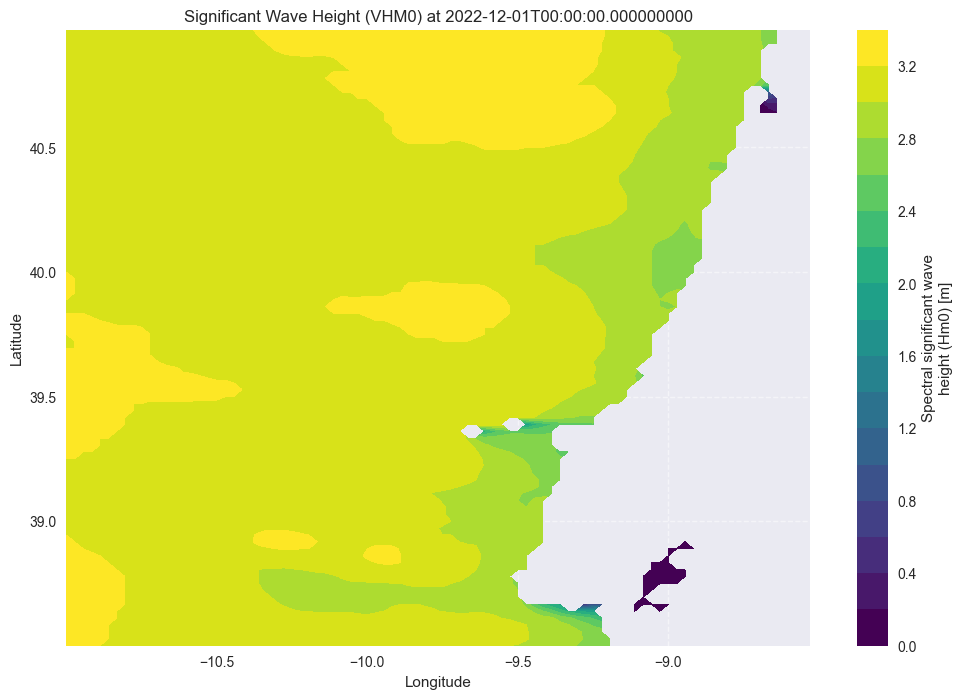

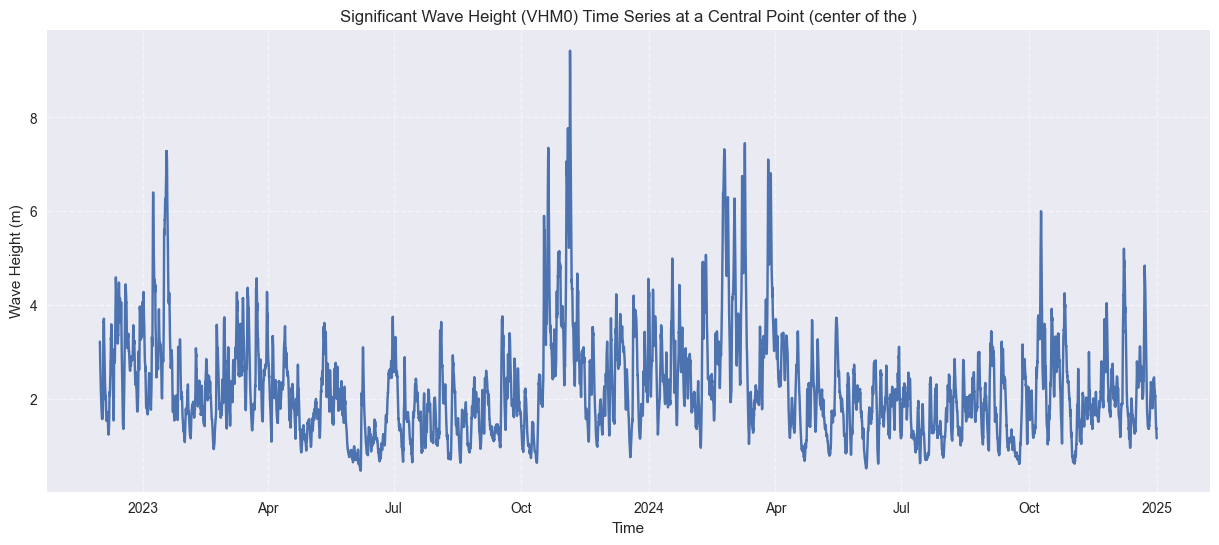

In [ ]:
import matplotlib.pyplot as plt

# Check if the dataset 'ds' was loaded successfully before trying to plot
if 'ds' in locals():

    # --- 1. Spatial Map Visualization ---
    plt.figure(figsize=(12, 8))
    # Select the VHM0 variable at the very first time step (time=0)
    first_step = ds['VHM0'].isel(time=0)
    
    # Create a contour plot
    first_step.plot.contourf(x='longitude', y='latitude', cmap='viridis', levels=20)
    
    plt.title(f"Significant Wave Height (VHM0) at {first_step.time.values}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


    # --- 2. Time Series Visualization ---
    plt.figure(figsize=(15, 6))
    
    # Select a central latitude and longitude point for the time series
    central_point = ds['VHM0'].sel(
        latitude=ds.latitude.values[len(ds.latitude)//2],
        longitude=ds.longitude.values[len(ds.longitude)//2],
        method='nearest'
    )
    
    # Plot the time series for the selected point
    central_point.plot()
    
    plt.title("Significant Wave Height (VHM0) Time Series at a Central Point (center of the )")
    plt.ylabel("Wave Height (m)")
    plt.xlabel("Time")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [ ]:
# Initial data exploration
print("Dataset Overview:")
print(f"Dimensions: {dict(ds.dims)}")
print(f"Coordinates: {list(ds.coords)}")
print(f"Data variables: {list(ds.data_vars)}")
print(f"\nTime range: {ds.time.values[0]} to {ds.time.values[-1]}")
print(f"Spatial extent: Lat {ds.latitude.values.min():.2f} to {ds.latitude.values.max():.2f}, "
      f"Lon {ds.longitude.values.min():.2f} to {ds.longitude.values.max():.2f}")

# Display basic statistics for VHM0
print("\nVHM0 Statistics:")
# --- FIX ---
# Calculate each statistic individually instead of using .describe()
print(f"  mean: {ds.VHM0.mean().values:.4f}")
print(f"  std:  {ds.VHM0.std().values:.4f}")
print(f"  min:  {ds.VHM0.min().values:.4f}")
print(f"  25%:  {ds.VHM0.quantile(0.25).values:.4f}")
print(f"  50%:  {ds.VHM0.quantile(0.50).values:.4f}")
print(f"  75%:  {ds.VHM0.quantile(0.75).values:.4f}")
print(f"  max:  {ds.VHM0.max().values:.4f}")

Dataset Overview:
Dimensions: {'time': 18289, 'latitude': 90, 'longitude': 90}
Coordinates: ['latitude', 'longitude', 'time']
Data variables: ['VCMX', 'VHM0', 'VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR', 'VMDR_SW1', 'VMDR_SW2', 'VMDR_WW', 'VMXL', 'VPED', 'VSDX', 'VSDY', 'VTM01_SW1', 'VTM01_SW2', 'VTM01_WW', 'VTM02', 'VTM10', 'VTPK']

Time range: 2022-12-01T00:00:00.000000000 to 2025-01-01T00:00:00.000000000
Spatial extent: Lat 38.50 to 40.97, Lon -11.00 to -8.53

VHM0 Statistics:
  mean: 2.2099
  std:  1.1065
  min:  0.0000
  25%:  1.4500
  50%:  2.0200
  75%:  2.7300
  max:  10.3800


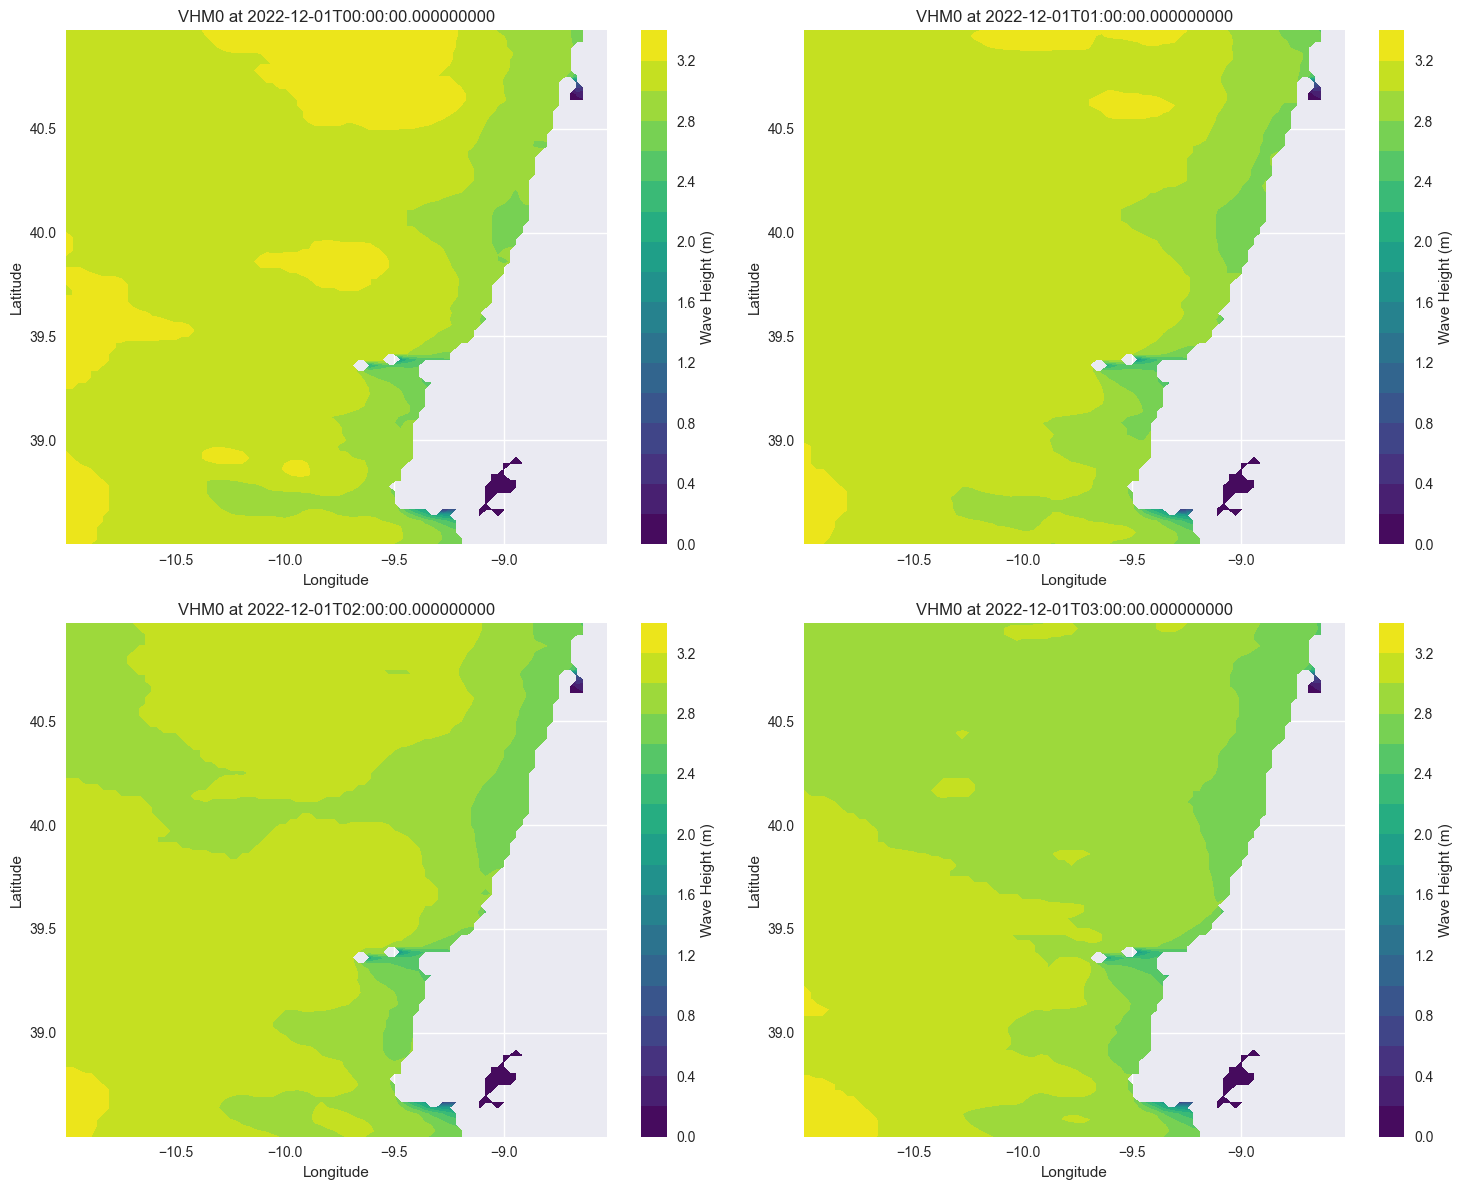

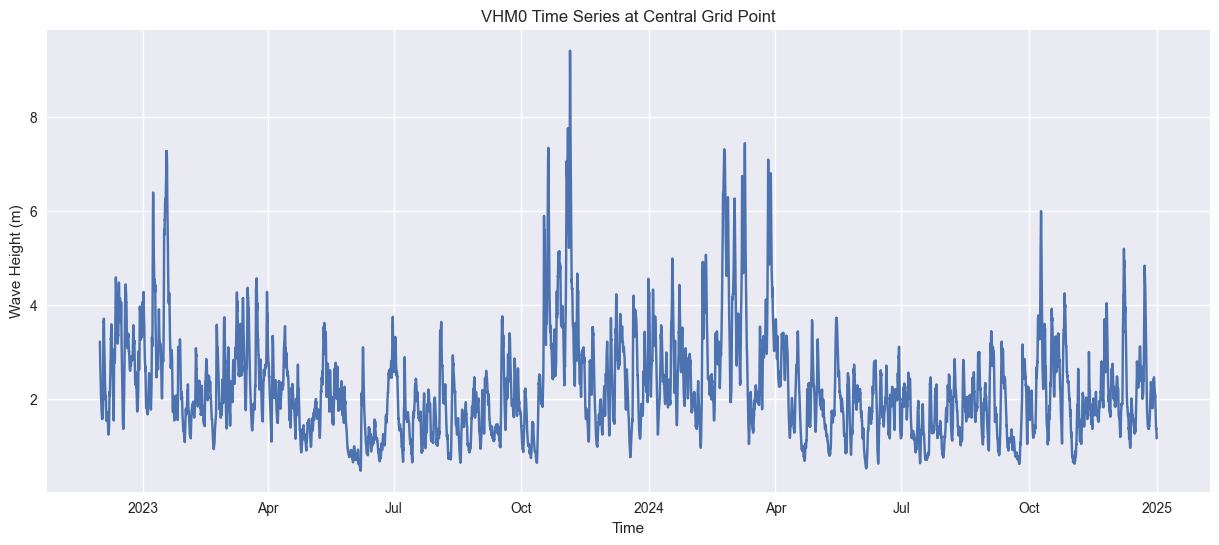

In [ ]:
# Visualize the first few time steps of VHM0
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i in range(4):
    im = axes[i].contourf(ds.longitude, ds.latitude, ds.VHM0.isel(time=i), 
                         levels=20, cmap='viridis')
    axes[i].set_title(f'VHM0 at {ds.time.values[i]}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    plt.colorbar(im, ax=axes[i], label='Wave Height (m)')

plt.tight_layout()
plt.show()

# Show temporal evolution at a central point
center_lat_idx = len(ds.latitude) // 2
center_lon_idx = len(ds.longitude) // 2

plt.figure(figsize=(15, 6))
ds.VHM0.isel(latitude=center_lat_idx, longitude=center_lon_idx).plot()
plt.title('VHM0 Time Series at Central Grid Point')
plt.ylabel('Wave Height (m)')
plt.show()

In [ ]:
for i in range(5):
    print(ds.time.values[i])

2022-12-01T00:00:00.000000000
2022-12-01T01:00:00.000000000
2022-12-01T02:00:00.000000000
2022-12-01T03:00:00.000000000
2022-12-01T04:00:00.000000000


## Step 2: Data Preprocessing and Feature Engineering

In [ ]:
# Define target and feature variables
target_var = 'VHM0'
feature_vars = ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR', 'VTPK', 'VSDX', 'VSDY']

print(f"Target variable: {target_var}")
print(f"Feature variables: {feature_vars}")

# Check for missing values
print("\nMissing values check:")
for var in [target_var] + feature_vars:
    missing_count = ds[var].isnull().sum().values
    print(f"{var}: {missing_count} missing values")

Target variable: VHM0
Feature variables: ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR', 'VTPK', 'VSDX', 'VSDY']

Missing values check:
VHM0: 31329057 missing values
VHM0_SW1: 31329057 missing values
VHM0_SW2: 31329057 missing values
VHM0_WW: 31329057 missing values
VMDR: 31329057 missing values
VTPK: 31329057 missing values
VSDX: 31329057 missing values
VSDY: 31329057 missing values


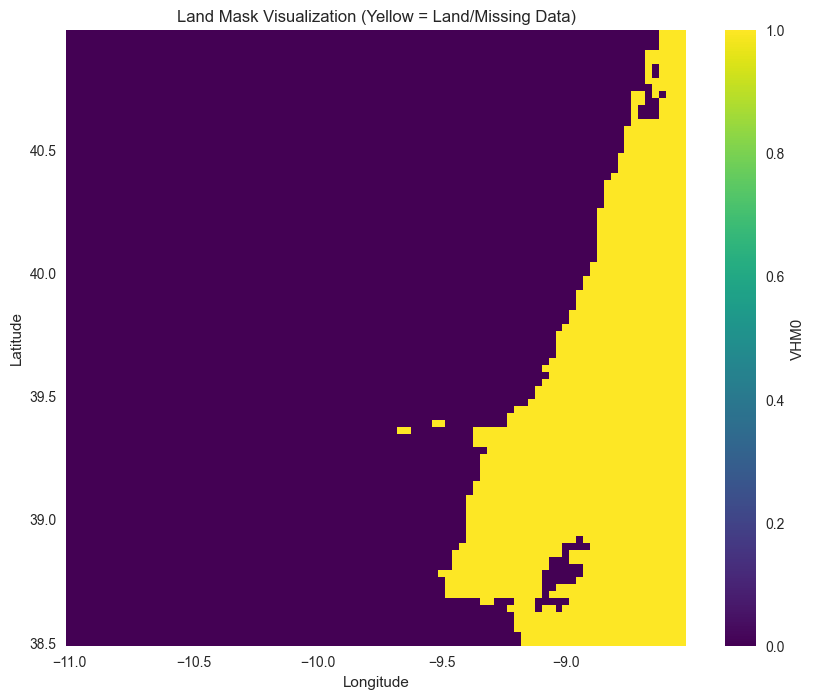

In [ ]:
# Check if the dataset 'ds' was loaded successfully
if 'ds' in locals():
    # --- Visualize the Land Mask ---
    plt.figure(figsize=(10, 8))
    
    # Create a boolean mask: True where VHM0 is NaN (land)
    land_mask = ds['VHM0'].isel(time=0).isnull()
    
    # Plot the mask
    land_mask.plot()
    
    plt.title("Land Mask Visualization (Yellow = Land/Missing Data)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [ ]:
# Check if the dataset 'ds' was loaded successfully
if 'ds' in locals():
    # --- Display Data in Tabular Format for a Single Ocean Point ---

    # Select a point in the middle of the ocean area
    ocean_point_ds = ds.sel(
        latitude=39.5, 
        longitude=-10.0, 
        method='nearest'
    )
    
    # Convert this single point's time series to a pandas DataFrame
    df_ocean_point = ocean_point_ds.to_dataframe()
    
    print("Data for a single point in the ocean (tabular format):")
    # Display the first 10 rows
    print(df_ocean_point.head(10))

Data for a single point in the ocean (tabular format):
                     VCMX  VHM0  VHM0_SW1  VHM0_SW2  VHM0_WW        VMDR  \
time                                                                       
2022-12-01 00:00:00  5.73  3.13      3.12      0.03     0.08  286.209998   
2022-12-01 01:00:00  5.62  3.07      3.07      0.02     0.12  286.209998   
2022-12-01 02:00:00  5.66  3.06      3.03      0.05     0.42  286.169998   
2022-12-01 03:00:00  5.59  3.02      2.97      0.15     0.50  285.779998   
2022-12-01 04:00:00  5.49  2.97      2.92      0.17     0.50  285.199998   
2022-12-01 05:00:00  5.43  2.93      2.88      0.13     0.50  285.529998   
2022-12-01 06:00:00  5.34  2.89      2.84      0.21     0.46  285.829998   
2022-12-01 07:00:00  5.21  2.83      2.78      0.17     0.36  285.849998   
2022-12-01 08:00:00  5.09  2.76      2.73      0.21     0.30  285.559998   
2022-12-01 09:00:00  4.95  2.69      2.65      0.23     0.34  285.429998   

                       VMDR_SW1 

In [ ]:
# Handle circular features (wave directions)
def convert_circular_features(data, circular_vars=['VMDR']):
    """
    Convert circular features to sine and cosine components.
    This properly represents the cyclical nature of directional data.
    """
    processed_data = data.copy()
    
    for var in circular_vars:
        if var in processed_data:
            # Convert degrees to radians
            radians = np.deg2rad(processed_data[var])
            
            # Create sine and cosine components
            processed_data[f'{var}_sin'] = np.sin(radians)
            processed_data[f'{var}_cos'] = np.cos(radians)
            
            # Remove original circular variable
            processed_data = processed_data.drop_vars(var)
            
            print(f"Converted {var} to {var}_sin and {var}_cos")
    
    return processed_data

# Apply circular feature conversion
ds_processed = convert_circular_features(ds, ['VMDR'])

# Update feature variables list
feature_vars = ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR_sin', 'VMDR_cos', 'VTPK', 'VSDX', 'VSDY']
print(f"\nUpdated feature variables: {feature_vars}")

Converted VMDR to VMDR_sin and VMDR_cos

Updated feature variables: ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR_sin', 'VMDR_cos', 'VTPK', 'VSDX', 'VSDY']


In [ ]:
# --- FIX: Convert data to a more memory-efficient format FIRST ---
print(f"Original memory usage: {ds_processed.nbytes / 1e9:.2f} GB")

# Loop through all data variables and cast them from float64 to float32
for var in ds_processed.data_vars:
    if ds_processed[var].dtype == 'float64':
        ds_processed[var] = ds_processed[var].astype('float32')

print(f"New memory usage after converting to float32: {ds_processed.nbytes / 1e9:.2f} GB")
# --- END FIX ---


# Before scaling, fill all NaN values (the land mask) with 0.
ds_filled = ds_processed.fillna(0)
print("\nFilled NaN values with 0.")


# Data scaling function
def scale_data(data, feature_vars, target_var, scaler_type='minmax'):
    """
    Scale the data using MinMaxScaler or StandardScaler.
    Handles 3D data (time, lat, lon) by reshaping for scaling.
    """
    scaled_data = data.copy()
    scalers = {}
    
    # Scale each variable
    all_vars = feature_vars + [target_var]
    
    for var in all_vars:
        # Create a new scaler for each variable
        if scaler_type == 'minmax':
            var_scaler = MinMaxScaler()
        else:
            var_scaler = StandardScaler()
        
        # Get the 3D array (time, lat, lon)
        var_data = data[var].values
        original_shape = var_data.shape
        
        # Reshape to 2D for scaling (flatten spatial dimensions)
        var_data_2d = var_data.reshape(original_shape[0], -1)
        
        # Fit and transform
        var_scaled_2d = var_scaler.fit_transform(var_data_2d)
        
        # Reshape back to original 3D shape
        var_scaled = var_scaled_2d.reshape(original_shape)
        
        # Update the dataset
        scaled_data[var] = (data[var].dims, var_scaled)
        
        # Store scaler for later inverse transformation
        scalers[var] = var_scaler
        
        print(f"Scaled {var}: min={var_scaled.min():.3f}, max={var_scaled.max():.3f}")
    
    return scaled_data, scalers

# Apply scaling
print("\nScaling data...")
ds_scaled, scalers = scale_data(ds_filled, feature_vars, target_var, scaler_type='minmax')
print("Data scaling completed!")

Original memory usage: 23.70 GB
New memory usage after converting to float32: 11.85 GB

Filled NaN values with 0.

Scaling data...
Scaled VHM0_SW1: min=0.000, max=1.000
Scaled VHM0_SW2: min=0.000, max=1.000
Scaled VHM0_WW: min=0.000, max=1.000
Scaled VMDR_sin: min=0.000, max=1.000
Scaled VMDR_cos: min=0.000, max=1.000
Scaled VTPK: min=0.000, max=1.000
Scaled VSDX: min=0.000, max=1.000
Scaled VSDY: min=0.000, max=1.000
Scaled VHM0: min=0.000, max=1.000
Data scaling completed!


In [ ]:
import numpy as np

# Check if the dataset 'ds' was loaded successfully
if 'ds' in locals():
    print("--- Selecting 5 Random Data Points for Validation ---\n")
    
    # Get the size of each dimension for random index selection
    time_size = ds.dims['time']
    lat_size = ds.dims['latitude']
    lon_size = ds.dims['longitude']
    
    for i in range(5):
        # Generate random indices for time, latitude, and longitude
        random_time_idx = np.random.randint(0, time_size)
        random_lat_idx = np.random.randint(0, lat_size)
        random_lon_idx = np.random.randint(0, lon_size)
        
        # Select the data at these random indices
        random_point = ds.isel(
            time=random_time_idx, 
            latitude=random_lat_idx, 
            longitude=random_lon_idx
        )
        
        # Get the significant wave height value to check for NaN
        vhm0_value = random_point['VHM0'].values
        
        print(f"--- Sample #{i+1} ---")
        print(f"Selected random indices -> Time: {random_time_idx}, Lat: {random_lat_idx}, Lon: {random_lon_idx}")
        
        # Check if the VHM0 value is NaN (which indicates it's a land point)
        if np.isnan(vhm0_value):
            print("Result: This is an INVALID point (on the land mask).")
            print(f"VHM0 value: {vhm0_value}\n")
        else:
            print("Result: This is a VALID ocean point.")
            print(f"  Timestamp: {random_point.time.values}")
            print(f"  Significant Wave Height (VHM0): {random_point.VHM0.values:.2f} m")
            print(f"  Peak Wave Period (VTPK): {random_point.VTPK.values:.2f} s")
            print(f"  Mean Wave Direction (VMDR): {random_point.VMDR.values:.2f} degrees\n")

--- Selecting 5 Random Data Points for Validation ---

--- Sample #1 ---
Selected random indices -> Time: 15795, Lat: 14, Lon: 71
Result: This is an INVALID point (on the land mask).
VHM0 value: nan

--- Sample #2 ---
Selected random indices -> Time: 11964, Lat: 20, Lon: 82
Result: This is an INVALID point (on the land mask).
VHM0 value: nan

--- Sample #3 ---
Selected random indices -> Time: 4426, Lat: 74, Lon: 87
Result: This is an INVALID point (on the land mask).
VHM0 value: nan

--- Sample #4 ---
Selected random indices -> Time: 11363, Lat: 23, Lon: 2
Result: This is a VALID ocean point.
  Timestamp: 2024-03-18T11:00:00.000000000
  Significant Wave Height (VHM0): 2.19 m
  Peak Wave Period (VTPK): 12.44 s
  Mean Wave Direction (VMDR): 287.01 degrees

--- Sample #5 ---
Selected random indices -> Time: 1685, Lat: 52, Lon: 1
Result: This is a VALID ocean point.
  Timestamp: 2023-02-09T05:00:00.000000000
  Significant Wave Height (VHM0): 2.60 m
  Peak Wave Period (VTPK): 14.07 s
  Mean

In [ ]:
import tensorflow as tf
import numpy as np

class WaveSequenceGenerator(tf.keras.utils.Sequence):
    """
    Custom Keras Sequence generator to create batches of data on-the-fly,
    avoiding MemoryErrors with large datasets.
    """
    def __init__(self, data, feature_vars, target_var, indices, lookback=24, batch_size=8):
        self.data = data
        self.feature_vars = feature_vars
        self.target_var = target_var
        self.indices = indices
        self.lookback = lookback
        self.batch_size = batch_size
        self.n_features = len(feature_vars)
        self.n_lat = data.dims['latitude']
        self.n_lon = data.dims['longitude']

    def __len__(self):
        # The number of batches per epoch
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        # Get the indices for the current batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Initialize the batch arrays
        X_batch = np.zeros((self.batch_size, self.lookback, self.n_lat, self.n_lon, self.n_features), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, self.n_lat, self.n_lon), dtype=np.float32)

        # Populate the batch
        for i, seq_start_idx in enumerate(batch_indices):
            seq_end_idx = seq_start_idx + self.lookback
            target_idx = seq_end_idx # Forecast horizon of 1
            
            # Populate features
            for j, var in enumerate(self.feature_vars):
                X_batch[i, :, :, :, j] = self.data[var].isel(time=slice(seq_start_idx, seq_end_idx)).values
            
            # Populate target
            y_batch[i, :, :] = self.data[self.target_var].isel(time=target_idx).values
            
        # Reshape target to match model output (add channel dimension)
        return X_batch, y_batch[..., np.newaxis]

In [ ]:
# --- REVISED DATA SPLITTING FOR GENERATOR ---

lookback_hours = 24
forecast_horizon = 1
batch_size = 8 # You can adjust this based on your GPU memory

# Calculate the total number of possible sequences from the original dataset
n_time = ds_scaled.dims['time']
n_sequences = n_time - lookback_hours - forecast_horizon + 1

# Create an array of all possible starting indices for our sequences
all_indices = np.arange(n_sequences)

# Chronologically split the INDICES, not the data itself
train_end = int(n_sequences * 0.7)
val_end = int(n_sequences * 0.85) # 70% train, 15% val, 15% test

train_indices = all_indices[:train_end]
val_indices = all_indices[train_end:val_end]
test_indices = all_indices[val_end:]

# Instantiate the generators using the split indices
train_generator = WaveSequenceGenerator(ds_scaled, feature_vars, target_var, train_indices, lookback=lookback_hours, batch_size=batch_size)
val_generator = WaveSequenceGenerator(ds_scaled, feature_vars, target_var, val_indices, lookback=lookback_hours, batch_size=batch_size)
test_generator = WaveSequenceGenerator(ds_scaled, feature_vars, target_var, test_indices, lookback=lookback_hours, batch_size=batch_size)

print("Data Generators created successfully!")
print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")
print(f"Test batches: {len(test_generator)}")

Data Generators created successfully!
Training batches: 1598
Validation batches: 342
Test batches: 342


## Step 3: Build the ConvLSTM Model Architecture

In [ ]:
# Build ConvLSTM model
def build_convlstm_model(input_shape, filters=[64, 32], kernel_size=(3, 3), dropout_rate=0.2):
    """
    Build a ConvLSTM model for spatiotemporal prediction.
    
    Parameters:
    - input_shape: (timesteps, height, width, features)
    - filters: list of filter numbers for each ConvLSTM layer
    - kernel_size: convolution kernel size
    - dropout_rate: dropout rate for regularization
    """
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # First ConvLSTM layer
    model.add(ConvLSTM2D(
        filters=filters[0],
        kernel_size=kernel_size,
        padding='same',
        return_sequences=True,
        activation='relu',
        recurrent_activation='hard_sigmoid',
        kernel_initializer='glorot_uniform'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second ConvLSTM layer (if more than one filter specified)
    if len(filters) > 1:
        model.add(ConvLSTM2D(
            filters=filters[1],
            kernel_size=kernel_size,
            padding='same',
            return_sequences=False,  # Last ConvLSTM layer
            activation='relu',
            recurrent_activation='hard_sigmoid',
            kernel_initializer='glorot_uniform'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer - single channel for VHM0 prediction
    model.add(Conv2D(
        filters=1,
        kernel_size=(1, 1),
        activation='linear',  # Linear activation for regression
        padding='same'
    ))
    
    return model

# --- FIX: Define input shape manually since X_train no longer exists ---
# (timesteps, height, width, features)
input_shape = (
    lookback_hours, 
    ds_scaled.dims['latitude'], 
    ds_scaled.dims['longitude'], 
    len(feature_vars)
)
print(f"Input shape for model: {input_shape}")

# Build the model
model = build_convlstm_model(input_shape, filters=[64, 32], dropout_rate=0.2)

# Display model architecture
model.summary()

# Plot model architecture
try:
    tf.keras.utils.plot_model(model, to_file='convlstm_model.png', show_shapes=True, show_layer_names=True)
    print("\nModel architecture saved as 'convlstm_model.png'")
except (ImportError, OSError):
    print("\nGraphviz not available for model visualization")

Input shape for model: (24, 90, 90, 8)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 24, 90, 90, 64) │       166,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 90, 90, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 90, 90, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 90, 90, 32)     │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,281 (1.06 MB)

 Trainable params: 277,089 (1.06 MB)

 Non-trainable params: 192 (768.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.

Model architecture saved as 'convlstm_model.png'


## Step 4: Compile and Train the Model

In [ ]:
# Custom loss function for better extreme wave prediction
def weighted_mse_loss(y_true, y_pred, weight_threshold=0.8):
    """
    Weighted MSE loss that penalizes underprediction of high wave heights more severely.
    This helps the model better capture extreme wave events.
    """
    # Standard MSE
    mse = tf.square(y_true - y_pred)
    
    # Create weights: higher weights for high wave heights
    weights = tf.where(y_true > weight_threshold, 2.0, 1.0)
    
    # Apply weights
    weighted_mse = weights * mse
    
    return tf.reduce_mean(weighted_mse)

# Custom metrics
def rmse(y_true, y_pred):
    """Root Mean Squared Error"""
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    """Mean Absolute Error"""
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# Compile the model
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)

model.compile(
    optimizer=optimizer,
    loss=weighted_mse_loss,  # Use weighted MSE for better extreme wave prediction
    metrics=[rmse, mae]
)

print("Model compiled successfully!")
print(f"Optimizer: Adam (lr=1e-4)")
print(f"Loss function: Weighted MSE")
print(f"Metrics: RMSE, MAE")

Model compiled successfully!
Optimizer: Adam (lr=1e-4)
Loss function: Weighted MSE
Metrics: RMSE, MAE


--- Testing on a single batch from the test generator ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Input batch shape: (8, 24, 90, 90, 8)
Prediction batch shape: (8, 90, 90, 1)
True target batch shape: (8, 90, 90, 1)

Evaluating performance on the single batch...
  - Loss (Weighted MSE): 0.0040
  - RMSE: 0.0634
  - MAE: 0.0558


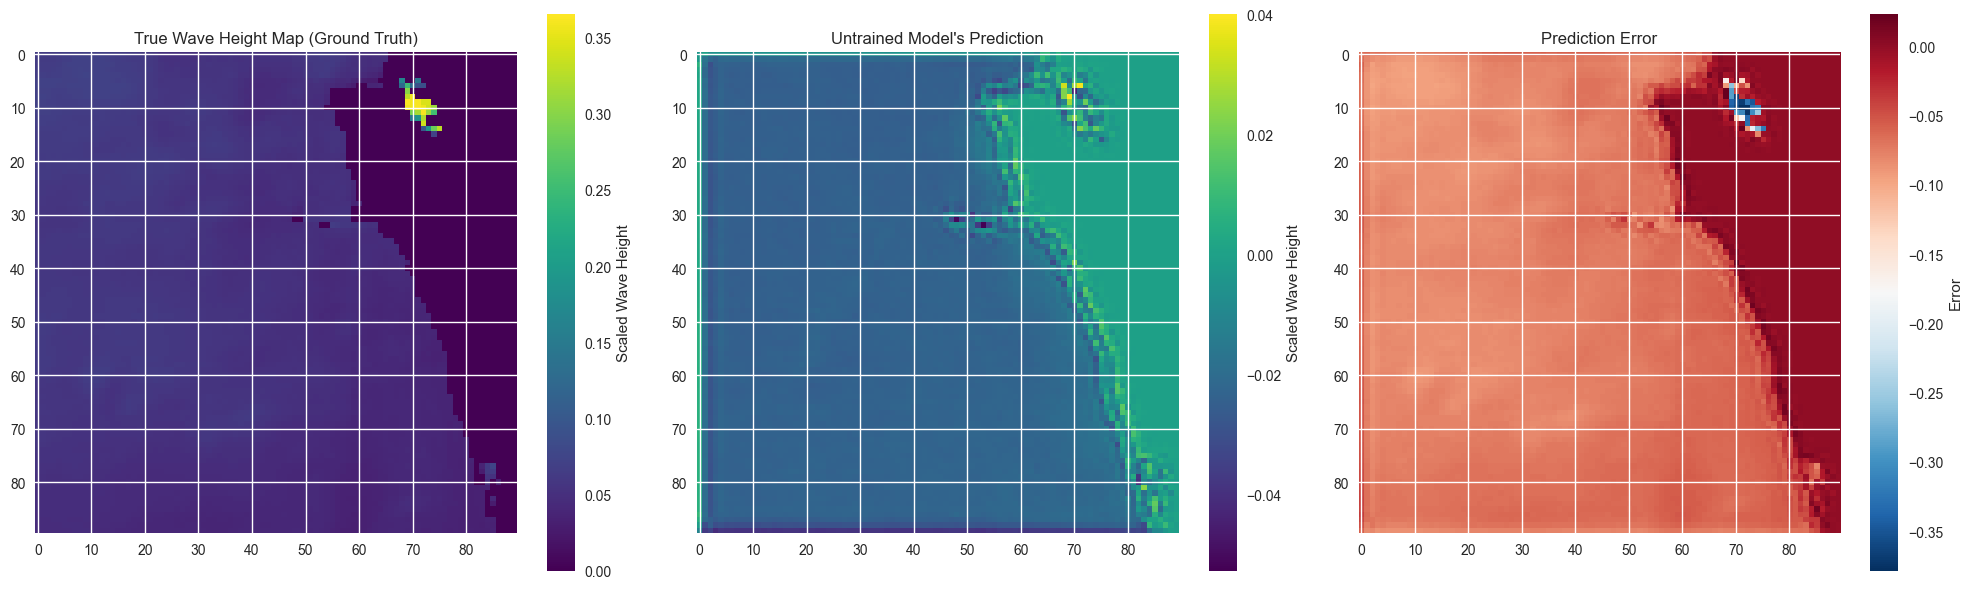

In [ ]:
# --- TEST ON A SINGLE BATCH ---

print("--- Testing on a single batch from the test generator ---")

# 1. Get one batch of data from the test generator
# The generator provides both the input (X) and the true target (y)
X_batch, y_batch = test_generator[0] 

# 2. Make a prediction with the UNTRAINED model
# The initial predictions will be essentially random as the model hasn't learned anything yet.
y_pred_batch = model.predict(X_batch)

print(f"\nInput batch shape: {X_batch.shape}")
print(f"Prediction batch shape: {y_pred_batch.shape}")
print(f"True target batch shape: {y_batch.shape}")

# 3. Evaluate the "accuracy" of the untrained model on this batch
# We expect the error to be high here. The goal is to ensure the code runs without errors.
print("\nEvaluating performance on the single batch...")
results = model.evaluate(X_batch, y_batch, verbose=0)

print(f"  - Loss (Weighted MSE): {results[0]:.4f}")
print(f"  - RMSE: {results[1]:.4f}")
print(f"  - MAE: {results[2]:.4f}")

# 4. Visualize the prediction for the first sample in the batch
# This shows what the model is trying to do: predict a 2D map.

# Get the first sample from the batch
true_map = y_batch[0].squeeze() # Squeeze removes the channel dimension for plotting
predicted_map = y_pred_batch[0].squeeze()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot the true map
im1 = axes[0].imshow(true_map, cmap='viridis')
axes[0].set_title("True Wave Height Map (Ground Truth)")
plt.colorbar(im1, ax=axes[0], label='Scaled Wave Height')

# Plot the predicted map
im2 = axes[1].imshow(predicted_map, cmap='viridis')
axes[1].set_title("Untrained Model's Prediction")
plt.colorbar(im2, ax=axes[1], label='Scaled Wave Height')

# Plot the error map
error_map = predicted_map - true_map
im3 = axes[2].imshow(error_map, cmap='RdBu_r')
axes[2].set_title("Prediction Error")
plt.colorbar(im3, ax=axes[2], label='Error')

plt.tight_layout()
plt.show()

In [ ]:
# Setup callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_convlstm_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured:")
print("- EarlyStopping: patience=15")
print("- ModelCheckpoint: save best model")
print("- ReduceLROnPlateau: reduce LR when validation loss plateaus")

Callbacks configured:
- EarlyStopping: patience=15
- ModelCheckpoint: save best model
- ReduceLROnPlateau: reduce LR when validation loss plateaus


In [ ]:
print("--- Starting model training for 5 epochs ---")

# Train the model using the generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Train for only 5 epochs for a quick test
    callbacks=callbacks,
    verbose=1
)  

print("\n--- Short training session completed! ---")

--- Starting model training for 5 epochs ---
Epoch 1/5
1121/1598 ━━━━━━━━━━━━━━━━━━━━ 1:10:23 9s/step - loss: 0.7501 - mae: 0.5688 - rmse: 0.8314

KeyboardInterrupt: 

In [ ]:
# Train the model
print("Starting model training...")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

# Reshape target data to match model output (add channel dimension)
y_train_reshaped = y_train[..., np.newaxis]
y_val_reshaped = y_val[..., np.newaxis]

# Training parameters
batch_size = 8  # Adjust based on GPU memory
epochs = 100

# Train the model
history = model.fit(
    X_train, y_train_reshaped,
    validation_data=(X_val, y_val_reshaped),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

In [ ]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # RMSE
    axes[0, 1].plot(history.history['rmse'], label='Training RMSE')
    axes[0, 1].plot(history.history['val_rmse'], label='Validation RMSE')
    axes[0, 1].set_title('Root Mean Squared Error')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # MAE
    axes[1, 0].plot(history.history['mae'], label='Training MAE')
    axes[1, 0].plot(history.history['val_mae'], label='Validation MAE')
    axes[1, 0].set_title('Mean Absolute Error')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning Rate (if available)
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'])
        axes[1, 1].set_title('Learning Rate')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True)
    else:
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Print final training metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_rmse = history.history['rmse'][-1]
final_val_rmse = history.history['val_rmse'][-1]

print(f"\nFinal Training Metrics:")
print(f"Training Loss: {final_train_loss:.6f}")
print(f"Validation Loss: {final_val_loss:.6f}")
print(f"Training RMSE: {final_train_rmse:.6f}")
print(f"Validation RMSE: {final_val_rmse:.6f}")

## Step 5: Evaluation and Visualization

In [ ]:
# Load the best model and evaluate on test data
print("Loading best model for evaluation...")
best_model = tf.keras.models.load_model('best_convlstm_model.h5', 
                                       custom_objects={'weighted_mse_loss': weighted_mse_loss,
                                                      'rmse': rmse, 'mae': mae})

# Reshape test target data
y_test_reshaped = y_test[..., np.newaxis]

# Evaluate on test set
print("Evaluating on test set...")
test_results = best_model.evaluate(X_test, y_test_reshaped, verbose=1)

print(f"\nTest Set Results:")
print(f"Test Loss: {test_results[0]:.6f}")
print(f"Test RMSE: {test_results[1]:.6f}")
print(f"Test MAE: {test_results[2]:.6f}")

# Make predictions on test set
print("\nGenerating predictions...")
y_pred = best_model.predict(X_test, verbose=1)
y_pred = y_pred.squeeze()  # Remove channel dimension

print(f"Predictions shape: {y_pred.shape}")
print(f"Test targets shape: {y_test.shape}")

In [ ]:
# Inverse transform predictions and targets to original scale
def inverse_transform_predictions(y_true, y_pred, scaler, original_shape):
    """
    Inverse transform scaled predictions back to original scale.
    """
    # Reshape for inverse transformation
    y_true_2d = y_true.reshape(-1, original_shape[1] * original_shape[2])
    y_pred_2d = y_pred.reshape(-1, original_shape[1] * original_shape[2])
    
    # Inverse transform
    y_true_orig = scaler.inverse_transform(y_true_2d)
    y_pred_orig = scaler.inverse_transform(y_pred_2d)
    
    # Reshape back to original shape
    y_true_orig = y_true_orig.reshape(original_shape)
    y_pred_orig = y_pred_orig.reshape(original_shape)
    
    return y_true_orig, y_pred_orig

# Inverse transform to original scale
target_scaler = scalers[target_var]
y_test_orig, y_pred_orig = inverse_transform_predictions(
    y_test, y_pred, target_scaler, y_test.shape
)

print("Predictions transformed back to original scale")
print(f"Original scale - Test min: {y_test_orig.min():.3f}, max: {y_test_orig.max():.3f}")
print(f"Original scale - Pred min: {y_pred_orig.min():.3f}, max: {y_pred_orig.max():.3f}")

# Calculate metrics on original scale
test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig.flatten(), y_pred_orig.flatten()))
test_mae_orig = mean_absolute_error(y_test_orig.flatten(), y_pred_orig.flatten())

print(f"\nOriginal Scale Metrics:")
print(f"RMSE: {test_rmse_orig:.4f} m")
print(f"MAE: {test_mae_orig:.4f} m")

In [ ]:
# Time series visualization at central grid point
def plot_time_series_comparison(y_true, y_pred, lat_idx=None, lon_idx=None, n_points=200):
    """
    Plot time series comparison between true and predicted values.
    """
    if lat_idx is None:
        lat_idx = y_true.shape[1] // 2
    if lon_idx is None:
        lon_idx = y_true.shape[2] // 2
    
    # Extract time series at specified grid point
    true_series = y_true[:n_points, lat_idx, lon_idx]
    pred_series = y_pred[:n_points, lat_idx, lon_idx]
    
    plt.figure(figsize=(15, 8))
    
    # Plot time series
    time_indices = np.arange(len(true_series))
    plt.plot(time_indices, true_series, label='True VHM0', alpha=0.8, linewidth=1.5)
    plt.plot(time_indices, pred_series, label='Predicted VHM0', alpha=0.8, linewidth=1.5)
    
    plt.title(f'VHM0 Time Series Comparison at Grid Point ({lat_idx}, {lon_idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Wave Height (m)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    correlation = np.corrcoef(true_series, pred_series)[0, 1]
    plt.text(0.02, 0.98, f'Correlation: {correlation:.3f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return correlation

# Plot time series comparison
correlation = plot_time_series_comparison(y_test_orig, y_pred_orig, n_points=200)
print(f"Time series correlation at central point: {correlation:.4f}")

In [ ]:
# Spatial map comparison
def plot_spatial_comparison(y_true, y_pred, time_idx=0, figsize=(18, 6)):
    """
    Plot spatial maps comparing true vs predicted wave heights.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # True values
    im1 = axes[0].imshow(y_true[time_idx], cmap='viridis', aspect='auto')
    axes[0].set_title('True VHM0')
    axes[0].set_xlabel('Longitude Index')
    axes[0].set_ylabel('Latitude Index')
    plt.colorbar(im1, ax=axes[0], label='Wave Height (m)')
    
    # Predicted values
    im2 = axes[1].imshow(y_pred[time_idx], cmap='viridis', aspect='auto')
    axes[1].set_title('Predicted VHM0')
    axes[1].set_xlabel('Longitude Index')
    axes[1].set_ylabel('Latitude Index')
    plt.colorbar(im2, ax=axes[1], label='Wave Height (m)')
    
    # Difference map
    diff = y_pred[time_idx] - y_true[time_idx]
    im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto', 
                        vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
    axes[2].set_title('Prediction Error (Pred - True)')
    axes[2].set_xlabel('Longitude Index')
    axes[2].set_ylabel('Latitude Index')
    plt.colorbar(im3, ax=axes[2], label='Error (m)')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate spatial statistics
    spatial_rmse = np.sqrt(np.mean(diff**2))
    spatial_mae = np.mean(np.abs(diff))
    spatial_corr = np.corrcoef(y_true[time_idx].flatten(), y_pred[time_idx].flatten())[0, 1]
    
    print(f"Spatial metrics for time step {time_idx}:")
    print(f"RMSE: {spatial_rmse:.4f} m")
    print(f"MAE: {spatial_mae:.4f} m")
    print(f"Correlation: {spatial_corr:.4f}")
    
    return spatial_rmse, spatial_mae, spatial_corr

# Find an interesting time step (high wave activity)
mean_wave_heights = np.mean(y_test_orig, axis=(1, 2))
high_wave_idx = np.argmax(mean_wave_heights)

print(f"Analyzing time step {high_wave_idx} (highest average wave height: {mean_wave_heights[high_wave_idx]:.3f} m)")
spatial_metrics = plot_spatial_comparison(y_test_orig, y_pred_orig, time_idx=high_wave_idx)

In [ ]:
# Additional evaluation metrics and visualizations
def comprehensive_evaluation(y_true, y_pred):
    """
    Comprehensive evaluation of model performance.
    """
    # Flatten arrays for overall statistics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Overall metrics
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    correlation = np.corrcoef(y_true_flat, y_pred_flat)[0, 1]
    
    # Bias and relative metrics
    bias = np.mean(y_pred_flat - y_true_flat)
    relative_rmse = rmse / np.mean(y_true_flat) * 100
    relative_mae = mae / np.mean(y_true_flat) * 100
    
    # Performance on extreme values (top 10%)
    extreme_threshold = np.percentile(y_true_flat, 90)
    extreme_mask = y_true_flat >= extreme_threshold
    extreme_rmse = np.sqrt(mean_squared_error(y_true_flat[extreme_mask], y_pred_flat[extreme_mask]))
    extreme_mae = mean_absolute_error(y_true_flat[extreme_mask], y_pred_flat[extreme_mask])
    
    print("=" * 50)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("=" * 50)
    print(f"Overall Performance:")
    print(f"  RMSE: {rmse:.4f} m")
    print(f"  MAE: {mae:.4f} m")
    print(f"  Correlation: {correlation:.4f}")
    print(f"  Bias: {bias:.4f} m")
    print(f"  Relative RMSE: {relative_rmse:.2f}%")
    print(f"  Relative MAE: {relative_mae:.2f}%")
    print(f"\nExtreme Wave Performance (>{extreme_threshold:.2f} m):")
    print(f"  Extreme RMSE: {extreme_rmse:.4f} m")
    print(f"  Extreme MAE: {extreme_mae:.4f} m")
    print(f"  Extreme samples: {np.sum(extreme_mask)} ({np.sum(extreme_mask)/len(y_true_flat)*100:.1f}%)")
    
    # Create scatter plot
    plt.figure(figsize=(12, 5))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true_flat[::100], y_pred_flat[::100], alpha=0.5, s=1)
    plt.plot([y_true_flat.min(), y_true_flat.max()], [y_true_flat.min(), y_true_flat.max()], 'r--', lw=2)
    plt.xlabel('True VHM0 (m)')
    plt.ylabel('Predicted VHM0 (m)')
    plt.title(f'Scatter Plot (R={correlation:.3f})')
    plt.grid(True, alpha=0.3)
    
    # Residual plot
    plt.subplot(1, 2, 2)
    residuals = y_pred_flat - y_true_flat
    plt.scatter(y_true_flat[::100], residuals[::100], alpha=0.5, s=1)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('True VHM0 (m)')
    plt.ylabel('Residuals (m)')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'rmse': rmse, 'mae': mae, 'correlation': correlation, 'bias': bias,
        'relative_rmse': relative_rmse, 'relative_mae': relative_mae,
        'extreme_rmse': extreme_rmse, 'extreme_mae': extreme_mae
    }

# Perform comprehensive evaluation
evaluation_results = comprehensive_evaluation(y_test_orig, y_pred_orig)

In [ ]:
# Save results and model summary
results_summary = {
    'model_architecture': 'ConvLSTM2D',
    'lookback_hours': lookback_hours,
    'input_shape': input_shape,
    'training_samples': X_train.shape[0],
    'validation_samples': X_val.shape[0],
    'test_samples': X_test.shape[0],
    'feature_variables': feature_vars,
    'target_variable': target_var,
    'evaluation_metrics': evaluation_results,
    'training_epochs': len(history.history['loss']),
    'best_val_loss': min(history.history['val_loss'])
}

# Save results to JSON
import json
with open('model_results.json', 'w') as f:
    # Convert numpy types to Python types for JSON serialization
    json_results = {}
    for key, value in results_summary.items():
        if isinstance(value, dict):
            json_results[key] = {k: float(v) if isinstance(v, (np.float32, np.float64)) else v 
                               for k, v in value.items()}
        elif isinstance(value, (np.float32, np.float64)):
            json_results[key] = float(value)
        elif isinstance(value, (np.int32, np.int64)):
            json_results[key] = int(value)
        else:
            json_results[key] = value
    
    json.dump(json_results, f, indent=2)

print("Results saved to 'model_results.json'")
print("\n" + "="*60)
print("MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Final Test RMSE: {evaluation_results['rmse']:.4f} m")
print(f"Final Test MAE: {evaluation_results['mae']:.4f} m")
print(f"Final Test Correlation: {evaluation_results['correlation']:.4f}")
print("\nFiles generated:")
print("- best_convlstm_model.h5 (trained model)")
print("- convlstm_model.png (model architecture, if graphviz available)")
print("- model_results.json (evaluation results)")